# Proyecto Final - Text Mining 2021
Garagiola Nazareno


### Pipeline:
---
tweets --▶      fasttext            --▶ KNN --▶ LDA
 
tweets --▶ CountVectorizer --▶ KMeans --▶ KNN --▶ LDA
       
---

## Getting started

In [ ]:
!python -m spacy download es_core_news_md > trash.txt

In [ ]:
import spacy
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import random

random.seed(10)
np.random.seed(10)

In [ ]:
from gensim.models import KeyedVectors

f = f"drive/MyDrive/tm_series/fasttext_spanish_twitter_100d.vec"

wordvectors = KeyedVectors.load_word2vec_format(f)

In [ ]:
with open('corpus.txt', 'r') as f:
    text = f.read()
    text = text.split('\n')
    corpus = list(set(text))
len(corpus)

19717

In [ ]:
with open('stopwords.txt','r') as f:
    es_stop = f.read().split('\n').append('via')

## Procesamiento

In [ ]:
import spacy
nlp = spacy.load("es_core_news_md")

In [ ]:
words = list()
for tw in corpus:
    for w in tw.split(' '):
        words.append(w.lower())

counter = Counter(words)

In [ ]:
def filter_token(token):
    return len(token.text) < 2 or token.is_punct or token.like_url or token.is_space or token.text[0]=='@'

def convert_listwords(list_words):
    text = ""
    for word in list_words:
        text = text + " " + word
    return text

def clean_tweets(corpus=corpus):
    """
    Funcion para filtrar las palabras de los tweets luego de procesarlas con 
    Spacy.
    Devuelve un diccionario que le asigna un ID a cada tweet.
    """
    data = {}
    for position, tweet in enumerate(corpus):
        doc = nlp(tweet)
        list_words = []
        for token in doc:
            if filter_token(token): continue
            list_words.append(token.text.lower())
        
        data[position] = {"tweet": convert_listwords(list_words), "vector": ''} 
    return data

def wv_clean_tweets(corpus=corpus):
    """
    Funcion similar a la de arriba, pero en este caso se usamos un embedding de
    FastText para asignarle un valor en forma de vector a cada tweet.
    Devuelve un diccionario que le asigna un ID a cada tweet.
    """
    data = {}
    for position, tweet in enumerate(corpus):
        doc = nlp(tweet)
        list_words = []
        vector_value = np.array([0 for i in range(100)], dtype=np.float64)
        for token in doc:
            if filter_token(token): continue
            if not (token.text.lower() in wordvectors.vocab): continue
            list_words.append(token.text.lower())
            vector_value += np.array(wordvectors.word_vec(token.text.lower()), dtype=np.float64)
        
        data[position] = {"tweet": convert_listwords(list_words), "vector": vector_value}
    return data

In [ ]:
data = clean_tweets(corpus[:5000])
clean = [data[i]['tweet'] for i in data]

In [ ]:
wv_data = wv_clean_tweets(corpus[:5000])
wv_vectors = [wv_data[i]['vector'] for i in wv_data]
wv_X = np.matrix(wv_vectors)

---
## Algoritmos

Para el proyecto utilizo los siguientes algoritmos y correspondientes implementaciones:

1. [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)
1. [VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html)
1. [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
1. [T-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
1. [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def vectorize(array, min_df):
    vectorizer = CountVectorizer(ngram_range=(1,1), stop_words=es_stop, min_df=min_df)
    matrix = vectorizer.fit_transform(array)
    return matrix

from sklearn.preprocessing import normalize
from sklearn.feature_selection import VarianceThreshold

VARIANCE_THRESHOLD = 1e-7
def transform(matrix):
    selector = VarianceThreshold(threshold=VARIANCE_THRESHOLD)
    normed_matrix = normalize(matrix, axis=1, norm='l1')
    reduced_matrix = selector.fit_transform(normed_matrix)
    return normed_matrix, reduced_matrix

In [ ]:
clean_X_10 = vectorize(clean, 10)
clean_X_20 = vectorize(clean, 20)
clean_X_30 = vectorize(clean, 30)
clean_X_40 = vectorize(clean, 40)
normed_X, transformed_X = transform(clean_X_40)

In [ ]:
for pos, key in enumerate(list(data.keys())):
    data[key]['vector'] = clean_X_40[pos]

In [ ]:
transformed_X.shape, wv_X.shape

((5000, 194), (5000, 100))

In [ ]:
from sklearn.cluster import KMeans

def sklearn_clustering(k, matrix):
    """
    Se usa la euclidea porque ya estan normalizados, y cosine normalizada 
    es parecida a euclidea.
    Retorna los labels de cada punto y una lista con las coordenadas de los 
    centroides de cada cluster.
    """
    clusterer = KMeans(n_clusters=k, random_state=10, n_init=20)
    clusterer.fit(X=matrix)
    return clusterer.labels_, clusterer.cluster_centers_

from sklearn.manifold import TSNE

def tsne_reduction(matrix):
    """
    Reduccion de dimensionalidad via T-sne para poder visualizar los datos
    """
    tsne = TSNE(n_components=2, random_state=10)
    tsne_data = tsne.fit_transform(matrix)
    return tsne_data

In [ ]:
NUM_CLUSTERS = 20

clean_sk_cluster, centers =  sklearn_clustering(NUM_CLUSTERS, transformed_X)
clean_tsne_data = tsne_reduction(transformed_X)

row = [(clean_tsne_data[i], clean_sk_cluster[i], clean[i]) for i in range(len(data))]
clean_df = pd.DataFrame(
    data=[(coords[0], coords[1], cluster, word) for coords, cluster, word in row],
    columns=["dim1", "dim2", "cluster", "tweet"]
)

# Creo que no haria falta hacer esto para los que vienen de los embeddings

# wv_cluster, centers = sklearn_clustering(20, wv_matrix)
# wv_tsne = tsne_reduction(wv_matrix)
# 
# ##Aca puedo intentar de guardar tambien algunas caracteristicas, podria seguir 
# ##reduciendo dimensionalidad, o anotar los centros de alguna forma!
# wv_row = [(wv_tsne[i], wv_cluster[i], clean[i]) for i in range(len(data))]
# wv_df = pd.DataFrame(
#     data=[(coords[0], coords[1], cluster, word) for coords, cluster, word in wv_row],
#     columns=["dim1", "dim2", "cluster", "tweet"]
# )

In [ ]:
def plot_all(df, colorbar=False):
    plt.figure(figsize=(22, 8))
    g = plt.scatter(x=df['dim1'],y=df['dim2'], s=10, c=df['cluster'], cmap='tab20', alpha=1)
    if colorbar: plt.colorbar(g)
    plt.show()

def show_cluster(df, n):
    msgs = list(df[df['cluster']==n]['tweet'])
    for msg in msgs:
        text = msg
        print(text)

def df_of_cluster(df, n):
    return df[df['cluster']==n]

from random import randint

def show_sample(df):
    for i in range(NUM_CLUSTERS):
        u = randint(0,NUM_CLUSTERS)
        msg = list(df[df['cluster']==i]['tweet'])[u]
        print(f"Cluster {i}. Sample: {msg}")

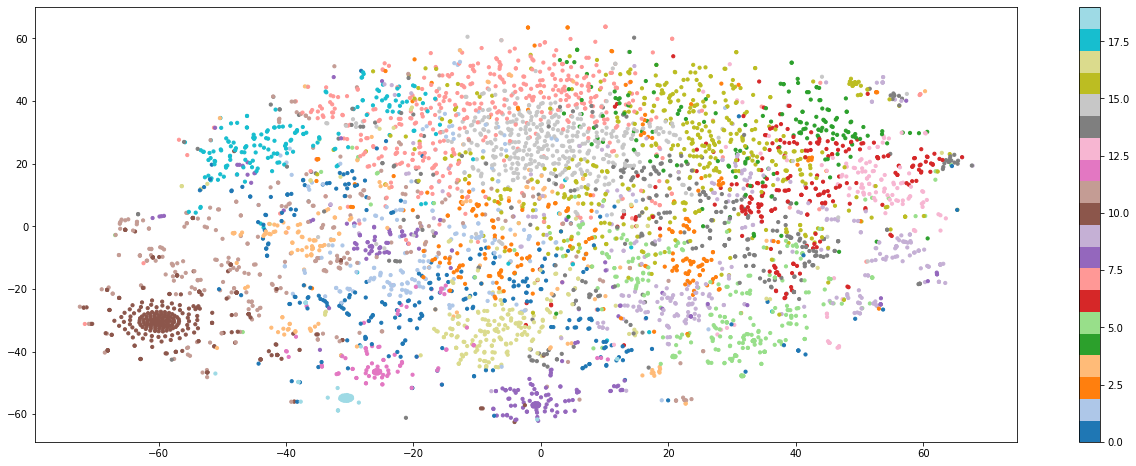

In [ ]:
plot_all(clean_df, True)

In [ ]:
show_sample(clean_df)

Cluster 0. Sample:  raconidas organiza otro torneo del juego del calamar con youtubers de roblox
Cluster 1. Sample:  de pana que vaina tan balurda la gente que se disfraza del juego del calamar
Cluster 2. Sample:  so hasta ahora el juego del calamar es como los juegos del hambre pero con juegos coreanos
Cluster 3. Sample:  es la segunda vez que sueno con el juego del calamar
Cluster 4. Sample:  entretenimiento el creador de el juego del calamar confirmo la segunda temporada la serie coreana destacada por convertirse en la mas vista de netflix tendra su secuela su director hizo algunos anticipos
Cluster 5. Sample:  hacerle caso leelo pensa el proximo domingo decile basta este conjunto de inescrupulosos el juego del calamar via
Cluster 6. Sample:  ese var es la propia encarnacion de la muneca de el juego del calamar no le pasa una seleccioncolombia
Cluster 7. Sample:  no sabia que ya estaba confirmada la segunda temporada del juego del calamar para mi quedo bastante bien pero bueno mient

In [ ]:
show_cluster(clean_df, 11)

---

In [ ]:
def export_cluster(df, k):
    new_df = df_of_cluster(df, k)
    new_df.to_pickle(f"drive/MyDrive/tm_series/clusters/corpus_{k}.pkl")

In [ ]:
data_file = open("drive/MyDrive/tm_series/data.pkl", "wb")
wv_data_file = open("drive/MyDrive/tm_series/wv_data.pkl", "wb")
pickle.dump(data, data_file)
pickle.dump(wv_data, wv_data_file)

#f = open("data.pkl", "rb")
#output = pickle.load(f)


In [ ]:
#for i in range(NUM_CLUSTERS):
#    export_cluster(clean_df, i)

---
## KNN

In [ ]:
df = pd.read_pickle(f"drive/MyDrive/tm_series/clusters/corpus_11.pkl")
#df = df_of_cluster(clean_df, 5)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def sklearn_KNN(X,y):
    classifier = KNeighborsClassifier(n_neighbors=3, p=2) #p=2 ==> euclidean
    classifier.fit(X,y)
    return classifier

from sklearn.decomposition import TruncatedSVD

def lsa_reduction(n_comp, matrix):
    svd = TruncatedSVD(n_components=n_comp)
    lsa_data = svd.fit_transform(X=matrix)
    return lsa_data

In [ ]:
tws = list()
tws_vects = list()
for j in df.index:
    tws.append(data[j]["tweet"])
    tws_vects.append(data[j]["vector"])

Clases identificadas en cluster 11:

- cansado
- gusta
- desagrado
- desinteres

In [ ]:
tws[29]  # data[544]['tweet']      #cansado
tws[26]  # data[489]['tweet']      #cansado
tws[288] # data[4989]['tweet']     #cansado
tws[262] # data[4751]['tweet']     #desagrado
tws[76]  # data[1441]['tweet']     #desagrado
tws[73]  # data[1329]['tweet']     #gusta
tws[95]  # data[1801]['tweet']     #gusta
tws[103] # data[1943]['tweet']     #gusta
tws[156] # data[3026]['tweet']     #gusta
tws[87]  # data[1645]['tweet']     #desinteres
tws[159] # data[3049]['tweet']     #desinteres

' hay que evitar el juego del calamar'

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
idx = np.array([29, 26, 288, 262, 76, 73, 95, 103, 156, 87, 159])
valoration = np.array(['cansado','cansado','cansado', 'desagrado','desagrado', 'gusta','gusta','gusta','gusta', 'desinteres','desinteres'])
labels = le.fit_transform(valoration)
feats = np.array([tws_vects[i] for i in idx])


In [ ]:
from scipy.sparse import csr_matrix
n = len(idx)
test = csr_matrix((n, transformed_X.shape[1]), dtype=np.int64)
for row in range(n):
    test[row] = feats[row]

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=3, p=2)
KNN.fit(test, labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Con estos tweets recopilados, la idea es poder hacer KNN con estos tweets como centros.

In [ ]:
prediction = KNN.predict(tws_vects[73])
tws[73], le.inverse_transform(prediction)

(' al final el juego del calamar si estuvo buena',
 array(['gusta'], dtype='<U10'))

In [ ]:
for i in range(len(tws)):
    print(f"{tws[i]}: {le.inverse_transform(KNN.predict(tws_vects[i]))}")

 mis vecinos estan viendo el juego del calamar: ['desagrado']
 squid game younow el juego del calamar: ['desagrado']
 entonces quiero pero siento como el juego del calamar jajajaa: ['desagrado']
 estan jugando el juego del calamar: ['desagrado']
 espnequipofcolombia debe hacerse como el juego del calamar para que se pongan pilas: ['cansado']
 jajajajaja esta jugando el juego del calamar: ['desagrado']
 jeno jaemin como soldados del juego del calamar aaaaaaaaa shotaro como el muneco del juego de las llaves sungchan como el joker suelten las demaaaas: ['desagrado']
 cosas que tal vez no sabias sobre el juego del calamar: ['cansado']
 el juego del calamar ciberdelincuentes estafan roban informacion con estos senuelos: ['cansado']
 cual te gusto mas,"el juego del calamar alice in borderland: ['desagrado']
 si el juego del calamar no. todo correcto: ['gusta']
 el 90 va con el disfraz del juego del calamar asi que vas ser original 100: ['cansado']
 video el juego del calamar al estilo tigres

In [ ]:
KNN.kneighbors(tws_vects)

---

---

---

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(clean_X_40, np.ones_like(clean), test_size=0.3)

In [ ]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.3)

In [ ]:
test = lsa_reduction(40, clean_X_40)

test_sk_cluster, centers =  sklearn_clustering(NUM_CLUSTERS, test)
test_tsne_data = tsne_reduction(test)

##Aca puedo intentar de guardar tambien algunas caracteristicas, podria seguir 
##reduciendo dimensionalidad, o anotar los centros de alguna forma!
row = [(test_tsne_data[i], test_sk_cluster[i], clean[i]) for i in range(len(data))]
test_df = pd.DataFrame(
    data=[(coords[0], coords[1], cluster, word) for coords, cluster, word in row],
    columns=["dim1", "dim2", "cluster", "tweet"]
)




---



In [ ]:
vectors_of_cluster = np.zeros(0)
for i in list(df.index):
    vectors_of_cluster = np.append(vectors_of_cluster, data[i+1]['vector'])


In [ ]:
vectors_of_cluster[0].shape


(1, 188)

In [ ]:
from scipy.sparse import csr_matrix
n = len(vectors_of_cluster)
test = csr_matrix((n, 188), dtype=np.int64)
for row in range(n):
    test[row] = vectors_of_cluster[row]

test.shape

In [ ]:
lsa_test = lsa_reduction(15, test)
lsa_test.shape

(15,)